In [1]:
import datetime as dt
from tracker.tracker import get_owned
from optimizer.ingestion import get_data
from optimizer.optimization import plot_results

In [2]:
# assets = get_owned()
# assets = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'BNB-USD']   # Crypto top 4 
assets = ['AMZN','AAPL', 'MSFT', 'FB']                  # SP500 top 4
# assets = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'BNB-USD', 'AMZN','AAPL', 'MSFT', 'FB'] # Combined

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=730)
delta_days = start_date - end_date

# start_date = dt.date(2021, 1, 1)
# end_date = dt.date(2021, 1, 23)

mean_returns, cov_matrix, delta_days = get_data(assets, start_date, end_date, log=False)


[*********************100%***********************]  4 of 4 completed


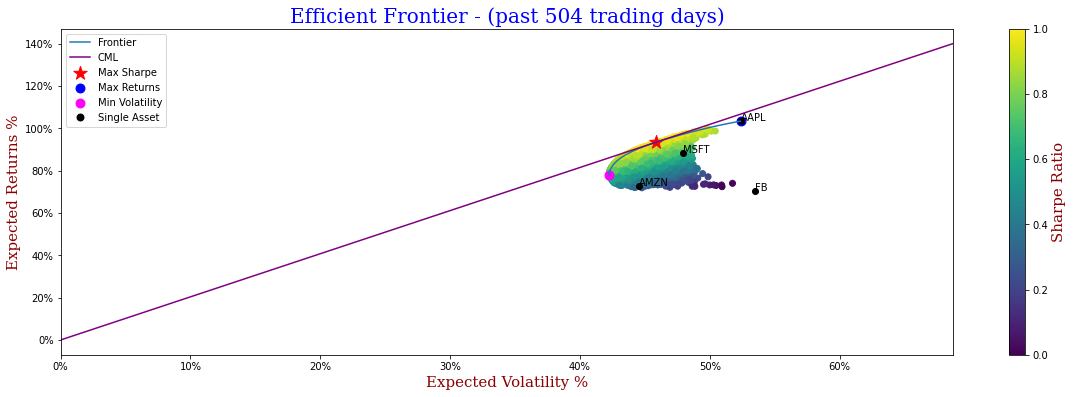

NameError: name 'max_rets_final' is not defined

In [3]:
plot_results(mean_returns, cov_matrix, delta_days, assets)